# Examples of configuring and running NSGA-II

This notebook includes two examples where NSGA-II is used to solve a continuous and a binary multi-objective problems.

In [1]:
include("../src/bounds.jl")
include("../src/solution.jl")
include("../src/operator.jl")
include("../src/continuousProblem.jl")
include("../src/binaryProblem.jl")
include("../src/algorithm.jl")
include("../src/component.jl")
include("../src/utils.jl")

using Dates

## Configure the algorithm to solve a continuous problem (Kursawe)

### Indicate the problem to solve

In [2]:
problem = kursaweProblem()

ContinuousProblem{Float64}(Bounds{Float64}[Bounds{Float64}(-5.0, 5.0), Bounds{Float64}(-5.0, 5.0), Bounds{Float64}(-5.0, 5.0)], Function[var"#45#47"{Int64}(3), var"#46#48"{Int64}(3)], Function[], "Kursawe")

### A solver contains the algorithm components and parameters

In [3]:
solver::NSGAII = NSGAII()
solver.problem = problem
solver.populationSize = 100

100

In [4]:
solver.termination = TerminationByEvaluations((numberOfEvaluationsToStop = 25000, ))
solver.mutation = PolynomialMutation((probability=1.0/numberOfVariables(problem), distributionIndex=20.0, bounds=problem.bounds))
solver.crossover = SBXCrossover((probability=1.0, distributionIndex=20.0, bounds=problem.bounds))

"""
# Alternative crossover operator
solver.crossover = BLXAlphaCrossover((probability=1.0, alpha=0.5, bounds=problem.bounds))
"""


"# Alternative crossover operator\nsolver.crossover = BLXAlphaCrossover((probability=1.0, alpha=0.5, bounds=problem.bounds))\n"

### Run the algorithm

In [5]:
startingTime = Dates.now()
optimize(solver)
endTime = Dates.now()

println("Computing time: ", (endTime - startingTime))

Computing time: 1259 milliseconds


### Print the results

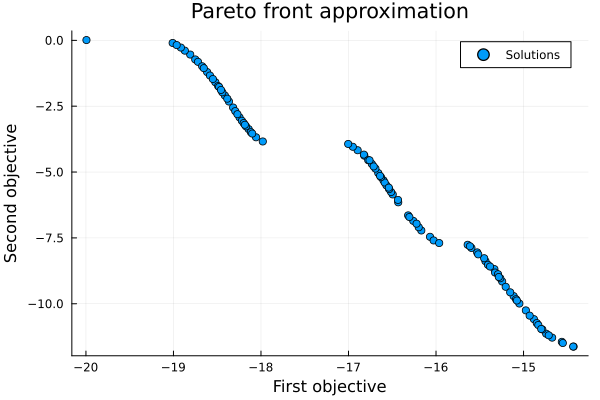

In [6]:
using Plots
 
#data to plot
x = [solution.objectives[1] for solution in solver.foundSolutions];
y = [solution.objectives[2] for solution in solver.foundSolutions];
 
gr();
 
scatter(x, y,  title = "Pareto front approximation", label = "Solutions")
xlabel!("First objective")
ylabel!("Second objective")

## Configure the algorithm to solve a binary problem (OneZeroMax)

In [8]:
problem = oneZeroMax(512)

BinaryProblem(512, Function[var"#104#107"(), var"#105#108"()], Function[], "OneZeroMax")

In [9]:
solver::NSGAII = NSGAII()
solver.problem = problem
solver.populationSize = 100

100

In [10]:
solver.termination = TerminationByEvaluations((numberOfEvaluationsToStop = 25000, ))
solver.mutation = BitFlipMutation((probability=1.0/numberOfVariables(problem),))
solver.crossover = SinglePointCrossover((probability=1.0, ))

SinglePointCrossover((probability = 1.0,), 2, 2, singlePointCrossover)

In [11]:
startingTime = Dates.now()
optimize(solver)
endTime = Dates.now()

println("Computing time: ", (endTime - startingTime))

Computing time: 1345 milliseconds


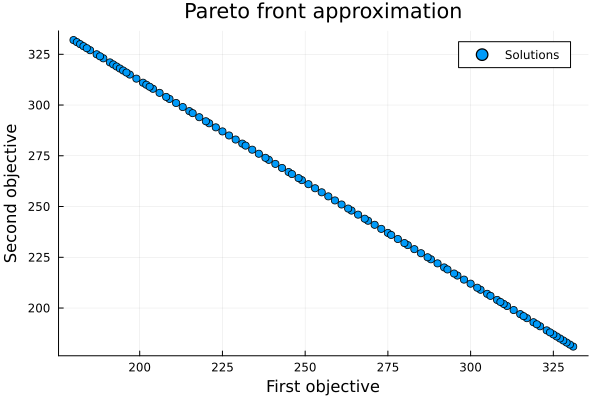

In [12]:
#data to plot
x = [solution.objectives[1] for solution in solver.foundSolutions];
y = [solution.objectives[2] for solution in solver.foundSolutions];
 
gr();
 
scatter(x, y,  title = "Pareto front approximation", label = "Solutions")
xlabel!("First objective")
ylabel!("Second objective")